In [1]:
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Randomly seeding
tf.random.set_seed(6950)
# Constants
SAMPLING_RATE = 500  # Hz
ecg_folder = "../../../Datasets/12-lead electrocardiogram database/ECGData"
diagnostics_file = "../../../Datasets/12-lead electrocardiogram database/Diagnostics.xlsx"
# Label mapping
# Basically to reduce 11 label to 4 for better performance on chapmanecg dataset
rhythm_mapping = {
    'AFIB': 'AFIB',
    'AF': 'AFIB',
    'SVT': 'GSVT',
    'AT': 'GSVT',
    'SAAWR': 'GSVT',
    'ST': 'GSVT',
    'AVNRT': 'GSVT',
    'AVRT': 'GSVT',
    'SB': 'SB',
    'SR': 'SR',
    'SA': 'SR'
}

2024-12-24 12:06:24.892364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 12:06:24.903216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 12:06:24.906533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 12:06:24.915527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 12:06:25.463807: W tensorflow/compiler/tf2


Model Performance:
--------------------------------------------------

MLP Results:
              precision    recall  f1-score   support

        AFIB       0.66      0.71      0.68       424
        GSVT       0.80      0.76      0.78       482
          SB       0.96      0.96      0.96       777
          SR       0.90      0.88      0.89       447

    accuracy                           0.85      2130
   macro avg       0.83      0.83      0.83      2130
weighted avg       0.85      0.85      0.85      2130

Cross-validation accuracy: 0.860 (+/- 0.016)

Decision Tree Results:
              precision    recall  f1-score   support

        AFIB       0.61      0.77      0.68       424
        GSVT       0.82      0.65      0.72       482
          SB       0.96      0.94      0.95       777
          SR       0.88      0.88      0.88       447

    accuracy                           0.83      2130
   macro avg       0.82      0.81      0.81      2130
weighted avg       0.84      0.

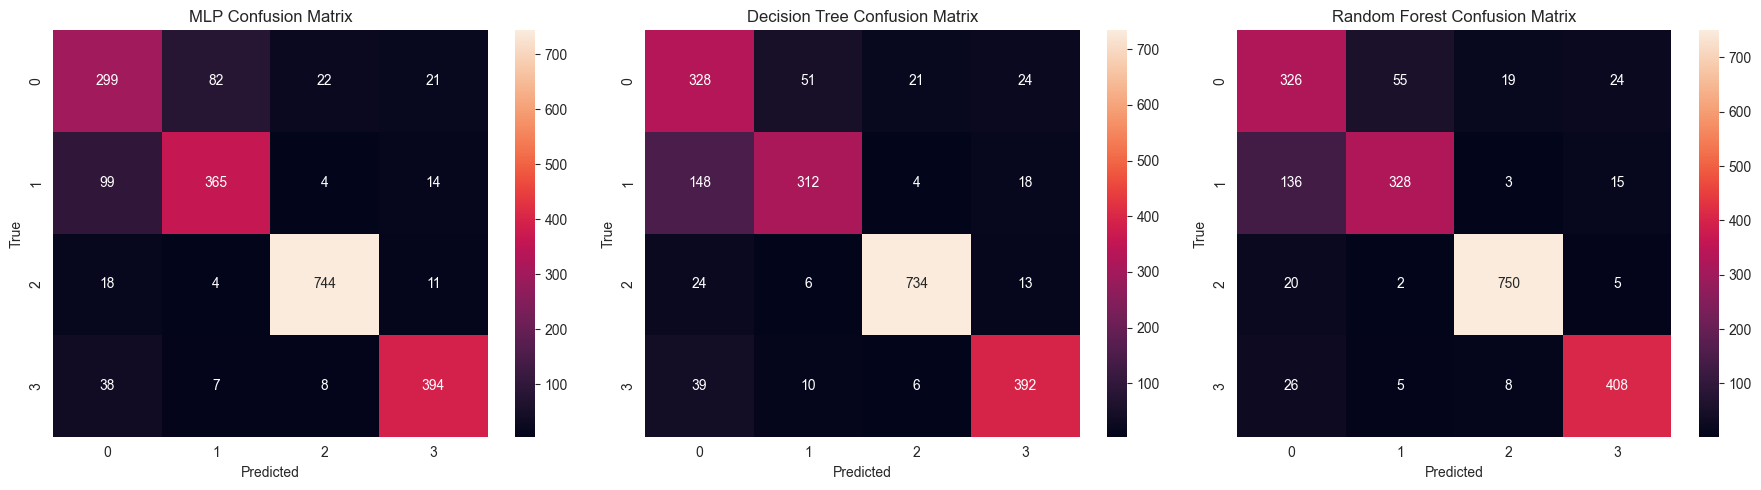

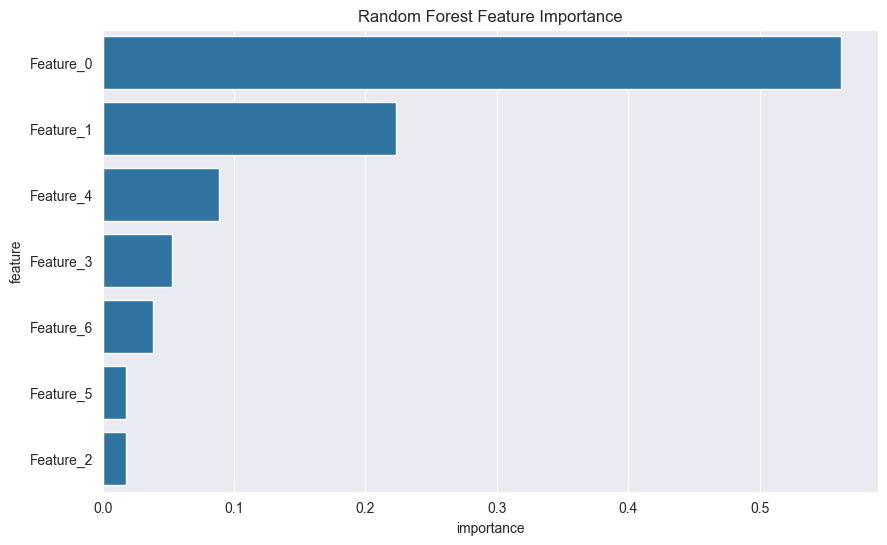

In [2]:
def detect_qrs_peaks(ecg_signal, sampling_rate=500):
    """
    QRS detection with optimized parameters
    """
    # Optimized parameters from tuning
    filter_low = 5.0
    filter_high = 50.0
    window_ms = 200
    threshold_ratio = 0.2

    # Bandpass filter
    nyquist_freq = sampling_rate / 2
    low = filter_low / nyquist_freq
    high = filter_high / nyquist_freq
    b, a = signal.butter(3, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)

    # Derivative and squaring
    derivative = np.diff(filtered_ecg)
    squared = derivative ** 2

    # Moving window integration
    window_size = int(window_ms / 1000 * sampling_rate)
    window = np.ones(window_size) / window_size
    integrated = np.convolve(squared, window, mode='same')

    # Adaptive thresholding
    peak_threshold = threshold_ratio * np.max(integrated)

    # Find peaks
    qrs_peaks, _ = signal.find_peaks(integrated, height=peak_threshold, distance=sampling_rate//2)

    return qrs_peaks, filtered_ecg

def extract_features(ecg_data, sampling_rate=500):
    """
    Extract features using optimized parameters
    """
    # Get lead II data
    lead_II = ecg_data[:, 1]

    # Get QRS peaks and filtered signal
    qrs_peaks, filtered_ecg = detect_qrs_peaks(lead_II, sampling_rate)

    features = {}

    # Calculate features (same as before)
    if len(qrs_peaks) > 1:
        rr_intervals = np.diff(qrs_peaks) / sampling_rate
        features['VentricularRate'] = 60 / np.mean(rr_intervals)
        features['RRVariability'] = np.std(rr_intervals)  # Added feature
    else:
        features['VentricularRate'] = 0
        features['RRVariability'] = 0

    # Add statistical features of the filtered signal
    features['SignalMean'] = np.mean(filtered_ecg)
    features['SignalStd'] = np.std(filtered_ecg)
    features['SignalSkew'] = np.mean((filtered_ecg - np.mean(filtered_ecg))**3) / (np.std(filtered_ecg)**3)

    # Add frequency domain features
    freqs, psd = signal.welch(filtered_ecg, fs=sampling_rate)
    features['PeakFreq'] = freqs[np.argmax(psd)]
    features['PowerInQRSBand'] = np.sum(psd[(freqs >= 10) & (freqs <= 25)])

    return list(features.values())

def load_and_preprocess_data(ecg_folder, diagnostics_file, rhythm_mapping):
    """
    Load and preprocess the ECG data
    """
    diagnostics = pd.read_excel(diagnostics_file)
    diagnostics['Rhythm'] = diagnostics['Rhythm'].map(rhythm_mapping)

    features_list = []
    labels = []

    for idx, row in diagnostics.iterrows():
        file_path = os.path.join(ecg_folder, row['FileName'] + '.csv')
        if os.path.exists(file_path):
            ecg_data = np.loadtxt(file_path, delimiter=',', skiprows=1)
            features = extract_features(ecg_data)
            features_list.append(features)
            labels.append(row['Rhythm'])

    return np.array(features_list), np.array(labels)

def plot_confusion_matrices(y_test, predictions_dict):
    """
    Plot confusion matrices for all models
    """
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    for ax, (model_name, y_pred) in zip(axes, predictions_dict.items()):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'{model_name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.show()

# Load and preprocess data
X, y = load_and_preprocess_data(ecg_folder, diagnostics_file, rhythm_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
}

# Train and evaluate models
predictions = {}
print("\nModel Performance:")
print("-" * 50)

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Print performance metrics
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Plot confusion matrices
plot_confusion_matrices(y_test, predictions)

# Feature importance for Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': [f'Feature_{i}' for i in range(X.shape[1])],
        'importance': rf_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Random Forest Feature Importance')
    plt.show()
